In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

# See basic information
we found there are 5 missing-value parameters.
['Age', 'Ticket', 'Fare', 'Cabin', 'Embarked']

* Age null ratio is 3.29
* Ticket null ratio is 4.62
* Fare null ratio is 0.13
* Cabin null ratio is 67.87
* Embarked null ratio is 0.25


In [2]:
ds_train = pd.read_csv('../input/tabular-playground-series-apr-2021/train.csv')
ds_test = pd.read_csv('../input/tabular-playground-series-apr-2021/test.csv')

PassengerId = ds_test.PassengerId
Survived = ds_train.Survived

dataset = pd.concat([ds_train, ds_test])
dataset = dataset.drop(['PassengerId'], axis=1)

print(ds_train.info())
print(ds_test.info())

for col in ds_train:
    unique = ds_train[col].value_counts().count()
    print(f'{col} unique: {unique}')
print('*****************************')
    
num_rows = len(ds_train.index)
for col in ds_train:
    col_null = ds_train[col].isnull().sum() 
    if col_null != 0:
        print(f'{col} null ratio is {(col_null/num_rows)*100}')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 12 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   PassengerId  100000 non-null  int64  
 1   Survived     100000 non-null  int64  
 2   Pclass       100000 non-null  int64  
 3   Name         100000 non-null  object 
 4   Sex          100000 non-null  object 
 5   Age          96708 non-null   float64
 6   SibSp        100000 non-null  int64  
 7   Parch        100000 non-null  int64  
 8   Ticket       95377 non-null   object 
 9   Fare         99866 non-null   float64
 10  Cabin        32134 non-null   object 
 11  Embarked     99750 non-null   object 
dtypes: float64(2), int64(5), object(5)
memory usage: 9.2+ MB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 11 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   PassengerId  100000 

# Data Visualization

In [ ]:
for i, col in enumerate(['Pclass', 'Sex', 'SibSp', 'Parch', 'Embarked']):
    sns.catplot(x=col, hue='Survived', data=ds_train, kind='count')

/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)


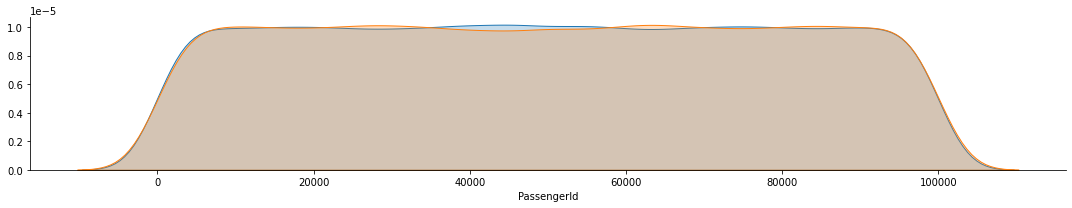

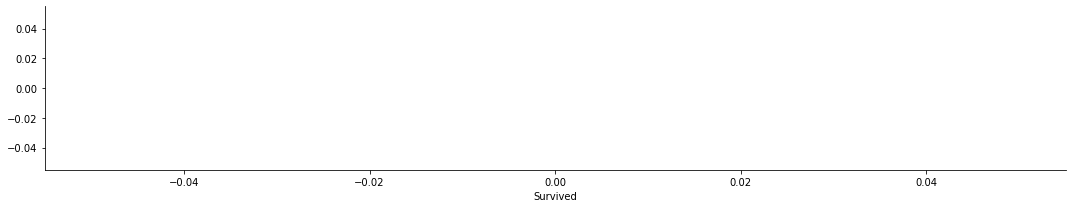

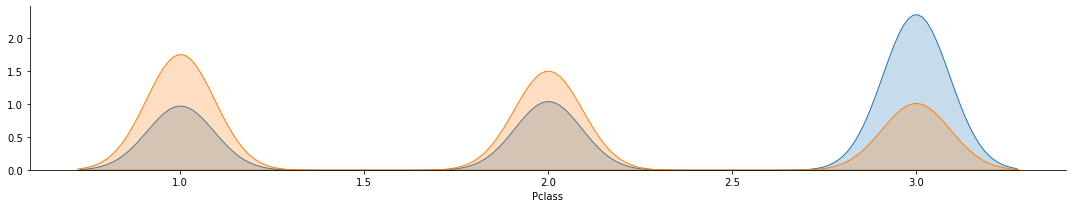

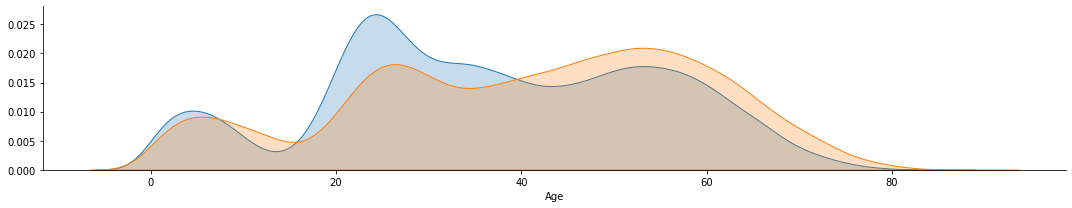

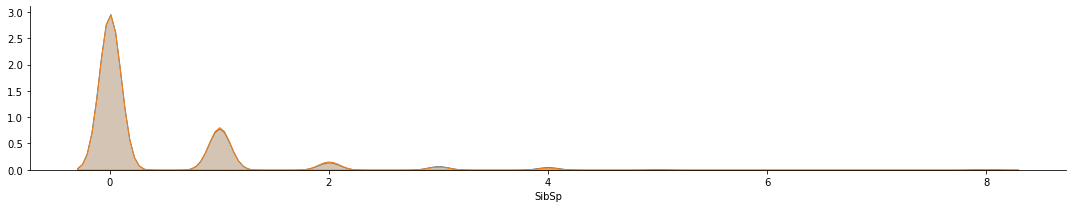

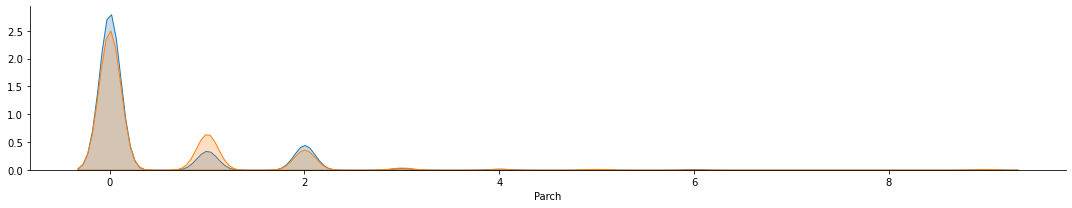

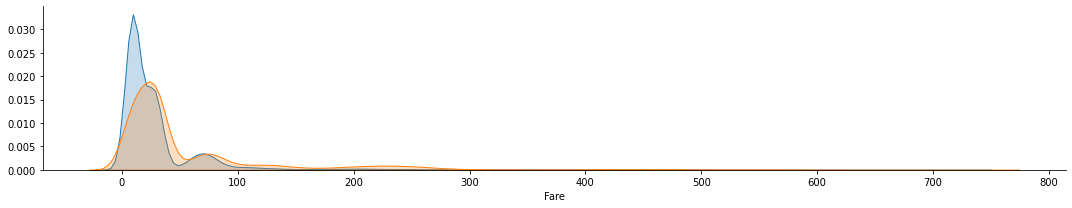

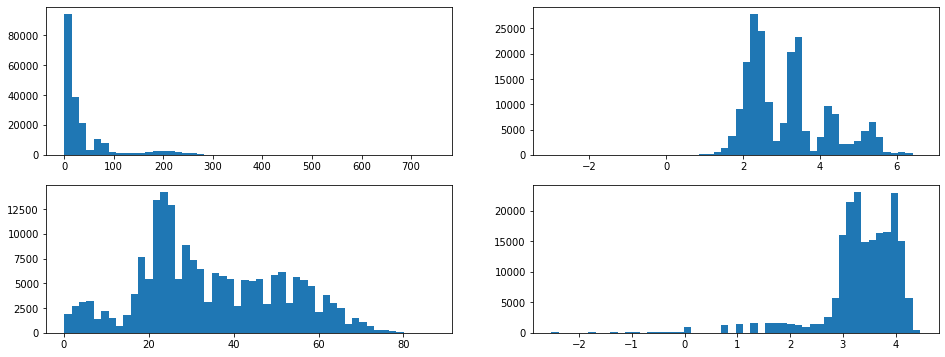

In [3]:
for i, col in enumerate(ds_train.columns):
    if ds_train[col].dtype != 'object':
        as_fig = sns.FacetGrid(data=ds_train, hue='Survived', aspect=5)
        as_fig.map(sns.kdeplot, col, shade=True)

fig, axes = plt.subplots(2,2,figsize=(16,6))
axes[0,0].hist(dataset['Fare'], bins=50)
axes[0,1].hist(np.log(np.clip(dataset['Fare'], 1e-100, 1e+100)), bins=50)
axes[1,0].hist(dataset['Age'], bins=50)
axes[1,1].hist(np.log(np.clip(dataset['Age'], 1e-100, 1e+100)), bins=50)
plt.show()

# Data explanatory

In [ ]:
## Name

Names = ds_train['Name'].values
first_name = []
last_name =[]
for name in Names:
    my_name = name.split(',')
    first_name.append(my_name[0].strip())
    last_name.append(my_name[1].strip())

print(len(dict.fromkeys(first_name).keys()))
print(len(dict.fromkeys(last_name).keys()))

honorific = []
# Does Name columns include honorific title?
for name in Names:
    if any(x in name for x in ['Mr', 'Ms', 'Miss', 'Dr']):
        honorific.append(name)

## Name doesn't have a honorific information.
## drop from dataset

In [ ]:
## Ticket
import re

ticket_dict = dict.fromkeys(dataset['Ticket'])
unique_ticket = list(ticket_dict)
print(len(unique_ticket))

ticket = dataset[['Ticket', 'Survived']].copy()
ticket['Ticket_num'] = ticket['Ticket'].apply(lambda x: re.sub('[a-zA-Z]+', '', str(x)).replace(' ', '').replace('.','').replace('/',''))
ticket['Ticket_cat'] = ticket['Ticket'].apply(lambda x: re.sub('[0-9]+', '', str(x)).replace(' ', '').replace('.','').replace('/',''))
#sns.catplot(x='Ticket_num', hue='Survived', data=ticket, kind='count')
dataset[dataset['Ticket'] == '10003']

In [ ]:
## Cabin
cabin = ds_train.loc[:, ['Cabin', 'Survived']].copy()
cabin['Cabin'] = cabin['Cabin'].fillna('N')
cabin['Cabin'] = cabin['Cabin'].map(lambda x: x[0])

sns.catplot(x='Cabin', hue='Survived', data=cabin, kind='count')

## Cabin type has a large effect to a result of life!!

## Stragegy ##
# 1. fillna with 'N'
# 2. replace cabin value with head of cabin name

In [64]:
# parch: The dataset defines family relations in this way...
# Parent = mother, father
# Child = daughter, son, stepdaughter, stepson
# Some children travelled only with a nanny, therefore parch=0 for them.

def calc_baby(data, age=3, condition=0):
    baby = data.loc[data['Age'] <= age, ['Age', 'SibSp', 'Parch', 'Survived']].copy()
    print(f'# of baby: {baby.shape[0]}')
    
    extracted = baby[baby['SibSp'] + baby['Parch'] == condition]
    death = extracted[extracted['Survived'] == 0]
       
    return (death.shape[0]/extracted.shape[0]) * 100

age = 1
print(f'Nanny-Baby death ratio: {calc_baby(dataset, age=age, condition=0):.2f}%')
print(f'Family-Baby death ratio: {calc_baby(dataset, age=age, condition=1):.2f}%')

# of baby: 1880
Nanny-Baby death ratio: 38.24%
# of baby: 1880
Family-Baby death ratio: 29.66%


In [88]:
# How many children are on Titanic alone?

children = dataset.loc[((dataset['Age'] <= 10) & (dataset['SibSp'] + dataset['Parch'])==0), :]

children

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1.0,1,"Oconnor, Frankie",male,NaN,2,0,209245,27.14,C12239,S
1,0.0,3,"Bryan, Drew",male,NaN,0,0,27323,13.35,NaN,S
3,0.0,3,"Kramer, James",male,19.0,0,0,A. 10866,13.04,NaN,S
4,1.0,3,"Bond, Michael",male,25.0,0,0,427635,7.76,NaN,S
5,0.0,2,"Sassano, Jonathan",male,35.0,0,0,13363,6.71,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...
99995,NaN,3,"Cash, Cheryle",female,27.0,0,0,7686,10.12,NaN,Q
99996,NaN,1,"Brown, Howard",male,59.0,1,0,13004,68.31,NaN,S
99997,NaN,3,"Lightfoot, Cameron",male,47.0,0,0,4383317,10.87,NaN,S
99998,NaN,1,"Jacobsen, Margaret",female,49.0,1,2,PC 26988,29.68,B20828,C


# Feature Engineering

In [ ]:
#dataset['Family'] = dataset['SibSp'] + dataset['Parch']
#    dataset.loc[dataset['Family'] == 0, 'Alone'] = 1
#    dataset['Alone'] = dataset['Alone'].fillna(value=0)